<b>Data mining project - 2020/21</b><br>
<b>Author</b>: [Alexandra Bradan](https://github.com/alexandrabradan)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 07/01/2021<b>

In [1]:
# general libraries
import sys
import math
import operator
import itertools
import collections
from collections import Counter
from collections import defaultdict
from IPython.display import Image

# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import arange
from numpy import unique
from numpy import argmax
from numpy import percentile

# scipy libraries
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import normaltest
from scipy.spatial import distance

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline as imbmake_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, recall_score, precision_score, classification_report, roc_auc_score 

In [2]:
data_directory = "../../../data/"
plot_directory = "../../../plots/DataUnderstanding/"
TR_cleaned_file = data_directory + "Cleaned_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "One_Hot_Encoding_Test_HR_Employee_Attrition.csv"

In [3]:
df_cleaned = pd.read_csv(TR_cleaned_file, sep=",") 

In [4]:
df_ts = pd.read_csv(TS_file , sep=",") 

In [5]:
df_cleaned.shape

(883, 36)

In [6]:
df_ts.shape

(219, 37)

In [7]:
del df_ts["JobRole_Manager"]

<h2> Split dataset in Training and Test set </h2>

In [8]:
y_train = df_cleaned["Attrition"]
df1 = df_cleaned.copy()
tmp_X_train = df1.drop('Attrition', axis=1)

y_test = df_ts["Attrition"]
df2 = df_ts.copy()
tmp_X_test = df2.drop('Attrition', axis=1)

In [9]:
def plot_classification_report(y_test, y_pred, cmap, title):
    clf_report = classification_report(y_test,
                                   y_pred,
                                   labels=np.arange(2),
                                   output_dict=True)
    clf_r = pd.DataFrame(clf_report).iloc[:-1, :].T
    # clf_r.iloc[2, 0] = np.nan
    # clf_r.iloc[2, 1] = np.nan
    sns.heatmap(clf_r, annot=True, cmap=cmap, cbar=False)
    plt.title(title)
    plt.show()

In [10]:
def enseble_knn_classifier(X_train, y_train, test_record, p):
    distances = {}
    sqr_n = math.ceil(math.sqrt(X_train.shape[0]))
    # print("sqr_n", sqr_n)
    for train_record, i in zip(X_train.itertuples(), range(0, X_train.shape[0])):
        dist = -1
        if p == 1:  # manathan distance
            dist = distance.cityblock(train_record, test_record)
        elif p == 2:  # euclidean distance
            dist = distance.euclidean(train_record, test_record)
        else:
            print("Wrong p=%s" % p)
        distances[str(i)] = dist
    max_range = -1
    if sqr_n % 2 == 0:
        max_range = sqr_n
    else:
        max_range = sqr_n + 1
    minClasses = []
    sorted_distances = OrderedDict(sorted(distances.items(), key=lambda t: t[1]))
    for i in range(0, max_range):
        sorted_index = int(list(sorted_distances.keys())[i])
        train_record_class = y_train[sorted_index]
        minClasses.append(train_record_class)
        
    SW = {}  # negative and positive class labels
    SW["0"] = 0 
    SW["1"] = 0
    for k in range(1, max_range, 2):  # odd neighbors
        for i in range(1, k + 1):
            train_record_class = int(minClasses[i])
            SW[str(train_record_class)] += (train_record_class + (1/math.log2(1 + i)))
    if SW["0"] > SW["1"]:
        return 0
    else:
        return 1

In [11]:
def draw_roc_auc(y_test, y_pred, roc_auc):
    plt.figure(figsize=(8, 5))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label='%0.4f' % (roc_auc))

    plt.plot([0, 1], [0, 1], 'k--', color="red", label='0.5000') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="lower right", title="AUC", frameon=True)
    # plt.title("Model %d's %s ROC-curve" % (model_name, type_flag))
    plt.show()

In [12]:
def perform_enseble_knn_classifier(X_train, X_test, y_train, y_test, p):
    y_pred = []
    for test_record in X_test.itertuples():
        pred = enseble_knn_classifier(X_train, y_train, test_record, p)
        y_pred.append(pred)
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_pred, average="weighted")
    print("roc_auc", roc_auc)
    draw_roc_auc(y_test, y_pred, roc_auc)

<h1>No normalisation or standardisation</h1>

In [13]:
X_train = tmp_X_train.copy()
X_test = tmp_X_test.copy()

<h2> p=1 (Manathan distance) </h2>

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       185
           1       0.10      0.21      0.14        34

    accuracy                           0.59       219
   macro avg       0.46      0.44      0.44       219
weighted avg       0.71      0.59      0.64       219

roc_auc 0.4353736089030206


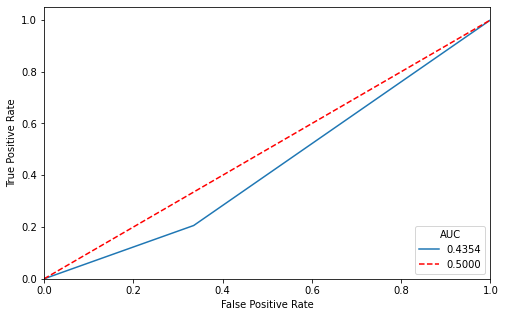

In [14]:
perform_enseble_knn_classifier(X_train, X_test, y_train, y_test, 1)

<h2> p=2 (Euclidean distance) </h2>

              precision    recall  f1-score   support

           0       0.83      0.69      0.76       185
           1       0.12      0.24      0.16        34

    accuracy                           0.62       219
   macro avg       0.48      0.46      0.46       219
weighted avg       0.72      0.62      0.66       219

roc_auc 0.4635930047694754


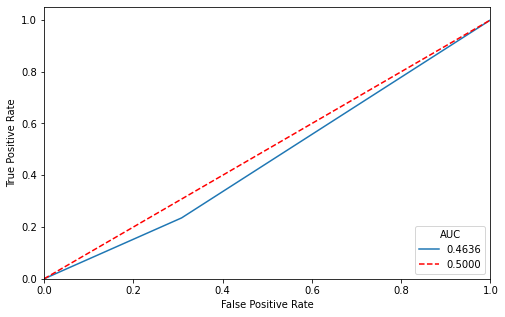

In [15]:
perform_enseble_knn_classifier(X_train, X_test, y_train, y_test, 2)

<h1>AbsMaxScaler</h1>

In [16]:
X_train = tmp_X_train.copy()
X_test = tmp_X_test.copy()
for column_name in X_train:
    scaler = MaxAbsScaler().fit(X_train[column_name].values.reshape(-1,1))
    X_train[column_name] = scaler.transform(X_train[column_name].values.reshape(-1,1))[:, 0]
    X_test[column_name] = scaler.transform(X_test[column_name].values.reshape(-1,1))[:, 0]

<h2> p=1 (Manathan distance) </h2>

              precision    recall  f1-score   support

           0       0.85      0.66      0.75       185
           1       0.17      0.38      0.24        34

    accuracy                           0.62       219
   macro avg       0.51      0.52      0.49       219
weighted avg       0.75      0.62      0.67       219

roc_auc 0.5236089030206676


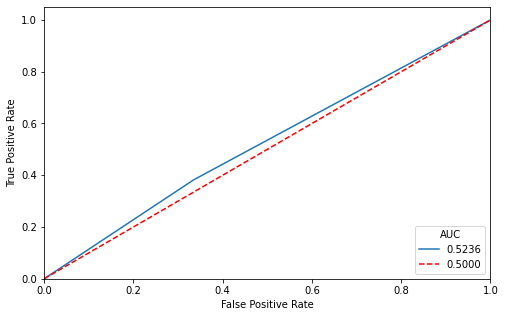

In [17]:
perform_enseble_knn_classifier(X_train, X_test, y_train, y_test, 1)

<h2> p=2 (Euclidean distance) </h2>

              precision    recall  f1-score   support

           0       0.84      0.67      0.74       185
           1       0.14      0.29      0.19        34

    accuracy                           0.61       219
   macro avg       0.49      0.48      0.47       219
weighted avg       0.73      0.61      0.66       219

roc_auc 0.48219395866454695


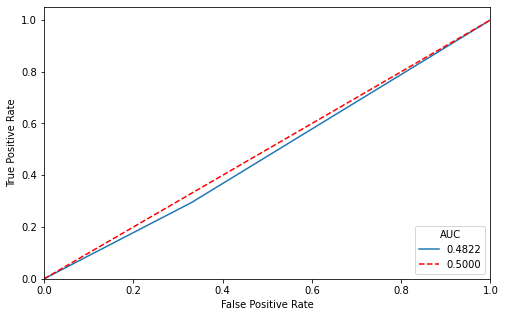

In [18]:
perform_enseble_knn_classifier(X_train, X_test, y_train, y_test, 2)

<h1>MinMaxScaler</h1>

In [19]:
X_train = tmp_X_train.copy()
X_test = tmp_X_test.copy()
for column_name in X_train:
    scaler = MinMaxScaler().fit(X_train[column_name].values.reshape(-1,1))
    X_train[column_name] = scaler.transform(X_train[column_name].values.reshape(-1,1))[:, 0]
    X_test[column_name] = scaler.transform(X_test[column_name].values.reshape(-1,1))[:, 0]

<h2> p=1 (Manathan distance) </h2>

              precision    recall  f1-score   support

           0       0.86      0.71      0.78       185
           1       0.18      0.35      0.24        34

    accuracy                           0.65       219
   macro avg       0.52      0.53      0.51       219
weighted avg       0.75      0.65      0.69       219

roc_auc 0.5305246422893481


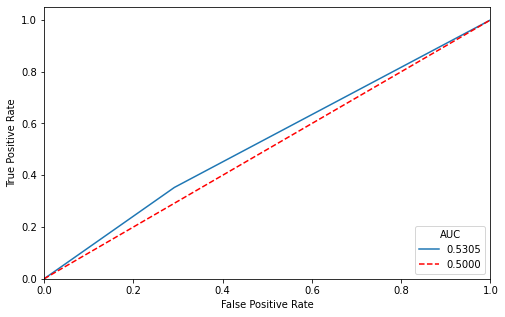

In [20]:
perform_enseble_knn_classifier(X_train, X_test, y_train, y_test, 1)

<h2> p=2 (Euclidean distance) </h2>

              precision    recall  f1-score   support

           0       0.85      0.68      0.75       185
           1       0.16      0.32      0.21        34

    accuracy                           0.63       219
   macro avg       0.50      0.50      0.48       219
weighted avg       0.74      0.63      0.67       219

roc_auc 0.5023052464228934


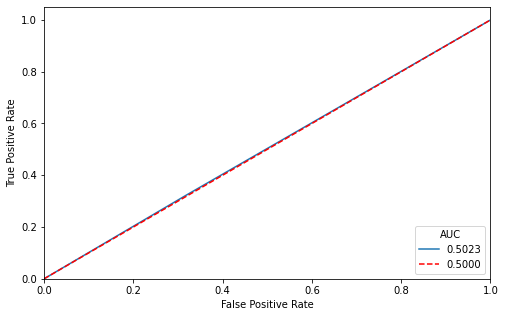

In [21]:
perform_enseble_knn_classifier(X_train, X_test, y_train, y_test, 2)

<h1>StandardScaler</h1>

In [22]:
X_train = tmp_X_train.copy()
X_test = tmp_X_test.copy()
for column_name in X_train:
    scaler = StandardScaler().fit(X_train[column_name].values.reshape(-1,1))
    X_train[column_name] = scaler.transform(X_train[column_name].values.reshape(-1,1))[:, 0]
    X_test[column_name] = scaler.transform(X_test[column_name].values.reshape(-1,1))[:, 0]

<h2> p=1 (Manathan distance) </h2>

              precision    recall  f1-score   support

           0       0.85      0.65      0.74       185
           1       0.17      0.38      0.23        34

    accuracy                           0.61       219
   macro avg       0.51      0.52      0.49       219
weighted avg       0.75      0.61      0.66       219

roc_auc 0.5182034976152623


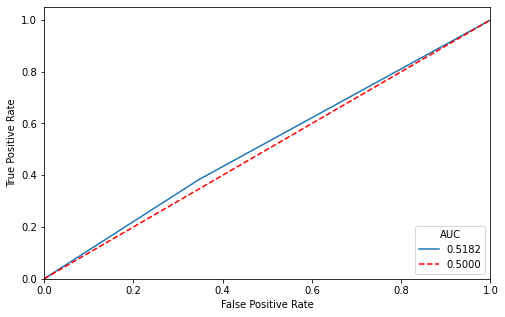

In [23]:
perform_enseble_knn_classifier(X_train, X_test, y_train, y_test, 1)

<h2> p=2 (Euclidean distance) </h2>

              precision    recall  f1-score   support

           0       0.84      0.66      0.74       185
           1       0.15      0.32      0.21        34

    accuracy                           0.61       219
   macro avg       0.50      0.49      0.47       219
weighted avg       0.74      0.61      0.66       219

roc_auc 0.49419713831478534


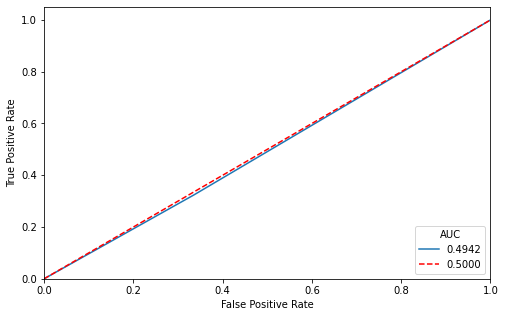

In [24]:
perform_enseble_knn_classifier(X_train, X_test, y_train, y_test, 2)

<h1>RobustScaler</h1>

In [25]:
X_train = tmp_X_train.copy()
X_test = tmp_X_test.copy()
for column_name in X_train:
    scaler = RobustScaler().fit(X_train[column_name].values.reshape(-1,1))
    X_train[column_name] = scaler.transform(X_train[column_name].values.reshape(-1,1))[:, 0]
    X_test[column_name] = scaler.transform(X_test[column_name].values.reshape(-1,1))[:, 0]

<h2> p=1 (Manathan distance) </h2>

              precision    recall  f1-score   support

           0       0.86      0.68      0.76       185
           1       0.18      0.38      0.25        34

    accuracy                           0.63       219
   macro avg       0.52      0.53      0.50       219
weighted avg       0.75      0.63      0.68       219

roc_auc 0.5317170111287758


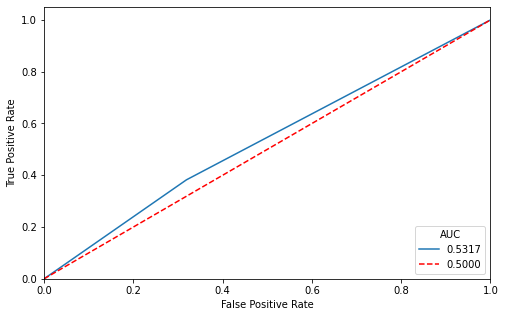

In [26]:
perform_enseble_knn_classifier(X_train, X_test, y_train, y_test, 1)

<h2> p=2 (Euclidean distance) </h2>

              precision    recall  f1-score   support

           0       0.87      0.66      0.75       185
           1       0.19      0.44      0.27        34

    accuracy                           0.63       219
   macro avg       0.53      0.55      0.51       219
weighted avg       0.76      0.63      0.67       219

roc_auc 0.5503179650238473


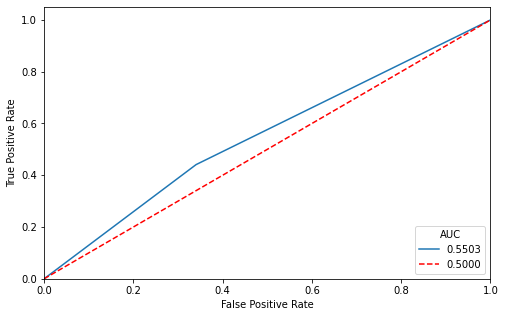

In [27]:
perform_enseble_knn_classifier(X_train, X_test, y_train, y_test, 2)